In [1]:
import libpysal 
import geopandas as gpd
import mapclassify

In [21]:
mapclassify.__version__

'2.3.0'

The example in this notebook use data on southern US counties from a built-in dataset available through `libpysal`. We use `libpysal` to obtain the path to the shapefile and then use `geopandas` to create a geodataframe from the shapefile:

In [2]:
pth = "../data/pcinc.shp"
gdf = gpd.read_file(pth)

In [3]:
gdf.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,...,2012,2013,2014,2015,2016,2017,2018,GeoFips_y,fips,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,...,35118,34946,36153,36915,36931,38644,40873,54000,54000,"POLYGON ((-81.74725 39.09538, -81.74635 39.096..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,...,41055,40659,43109,45287,45684,47869,50070,12000,12000,"MULTIPOLYGON (((-86.38865 30.99418, -86.38385 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,...,46044,47113,49444,51519,52273,53943,56839,17000,17000,"POLYGON ((-91.18529 40.63780, -91.17510 40.643..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,...,47860,47941,50254,52315,53209,54919,57515,27000,27000,"POLYGON ((-96.78438 46.63050, -96.78434 46.630..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,...,53546,53052,54687,57139,59029,60512,63354,24000,24000,"POLYGON ((-77.45881 39.22027, -77.45866 39.220..."


In [7]:
pci_2018 = gdf['2018']
q10 = mapclassify.Quantiles(pci_2018, k=10)
q10

Quantiles                   

      Interval         Count
----------------------------
[37834.00, 43078.00] |     5
(43078.00, 46186.60] |     5
(46186.60, 46999.60] |     5
(46999.60, 48772.20] |     5
(48772.20, 50355.00] |     5
(50355.00, 52448.80] |     4
(52448.80, 55915.80] |     5
(55915.80, 59218.00] |     5
(59218.00, 64492.80] |     5
(64492.80, 82005.00] |     5

Here we see the 10 classes, but without more specific information on the legend, the user has to know that 0 is the first declile and 9 the 10th. We also do not know the values that define these classes. 

We can rectify this as follows:

In [8]:
q10.get_legend_classes()

['[37834.00, 43078.00]',
 '(43078.00, 46186.60]',
 '(46186.60, 46999.60]',
 '(46999.60, 48772.20]',
 '(48772.20, 50355.00]',
 '(50355.00, 52448.80]',
 '(52448.80, 55915.80]',
 '(55915.80, 59218.00]',
 '(59218.00, 64492.80]',
 '(64492.80, 82005.00]']

In [9]:
mapping = dict([(i,s) for i,s in enumerate(q10.get_legend_classes())])

In [10]:
mapping

{0: '[37834.00, 43078.00]',
 1: '(43078.00, 46186.60]',
 2: '(46186.60, 46999.60]',
 3: '(46999.60, 48772.20]',
 4: '(48772.20, 50355.00]',
 5: '(50355.00, 52448.80]',
 6: '(52448.80, 55915.80]',
 7: '(55915.80, 59218.00]',
 8: '(59218.00, 64492.80]',
 9: '(64492.80, 82005.00]'}

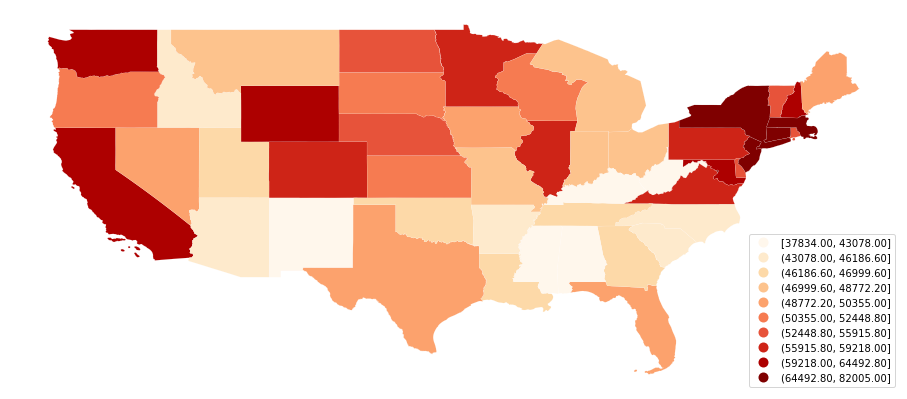

In [11]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

import matplotlib.pyplot as plt
f, ax = plt.subplots(1, figsize=(16, 9))
gdf.assign(cl=q10.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True,
                          legend_kwds={'loc': 'lower right'})
ax.set_axis_off()
replace_legend_items(ax.get_legend(), mapping)
plt.show()

## Interactive Exploration of Choropleth Classification

Next, we develop a small application that relies on `mapclassify` together with [palettable](https://jiffyclub.github.io/palettable/) and [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/) to explore the choice of:

- classification method
- number of classes
- colormap



In [12]:
from palettable import colorbrewer
sequential = colorbrewer.COLOR_MAPS['Sequential']
diverging = colorbrewer.COLOR_MAPS['Diverging']
qualitative = colorbrewer.COLOR_MAPS['Qualitative']



In [13]:
sequential.keys()

dict_keys(['Blues', 'BuGn', 'BuPu', 'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu', 'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd'])

In [17]:
from ipywidgets import interact, Dropdown, RadioButtons, IntSlider, VBox, HBox, FloatSlider, Button, Label

k_classifiers = {
    'equal_interval': mapclassify.EqualInterval,
    'fisher_jenks': mapclassify.FisherJenks,
    'jenks_caspall': mapclassify.JenksCaspall,
    'jenks_caspall_forced': mapclassify.JenksCaspallForced,
    'maximum_breaks': mapclassify.MaximumBreaks,
    'natural_breaks': mapclassify.NaturalBreaks,
    'quantiles': mapclassify.Quantiles,
    }

def k_values(ctype, cmap):
    k = list(colorbrewer.COLOR_MAPS[ctype][cmap].keys())
    return list(map(int, k))
    
def update_map(method='quantiles', k=5, cmap='Blues', year='2018'):
    classifier = k_classifiers[method](gdf[year],k=k)
    mapping = dict([(i,s) for i,s in enumerate(classifier.get_legend_classes())])
    #print(classifier)
    f, ax = plt.subplots(1, figsize=(16, 9))
    gdf.assign(cl=classifier.yb).plot(column='cl', categorical=True, \
        k=k, cmap=cmap, linewidth=0.1, ax=ax, \
        edgecolor='grey', legend=True, \
        legend_kwds={'loc': 'lower right'})
    ax.set_axis_off()
    ax.set_title(f'Per Capita Income {year}')
    replace_legend_items(ax.get_legend(), mapping)

    plt.show()
    


data_type = RadioButtons(options=['Sequential', 'Diverging', 'Qualitative']) # options for data type

bindings = {'Sequential': range(3,9+1),
            'Diverging': range(3,11+1),
            'Qualitative': range(3,12+1)}

cmap_bindings = {'Sequential': list(sequential.keys()),
                 'Diverging': list(diverging.keys()),
                 'Qualitative': list(qualitative.keys())}

class_val = Dropdown(options=bindings[data_type.value])  # ocjjptions for number of classes
cmap_val = Dropdown(options=cmap_bindings[data_type.value]) # options for colormaps for data type

def type_change(change):
    class_val.options = bindings[change['new']]
    cmap_val.options = cmap_bindings[change['new']]

def cmap_change(change):
    cmap=change['new']
    ctype = data_type.value
    k = k_values(ctype, cmap)
    class_val.options = k
    
data_type.observe(type_change, names=['value'])
cmap_val.observe(cmap_change, names=['value'])


from ipywidgets import Output, Tab
out = Output()
#t = Tab()
#t.children = [out]
#t

# In this case, the interact function must be defined after the conditions stated above...
# therefore, the k now depends on the radio button 

with out:
    interact(update_map, method=list(k_classifiers.keys()), cmap=cmap_val, k = class_val)
   

display(VBox([data_type, out]))



Changing the type of colormap (sequential, diverging, qualitative) will update the options for the available color maps (`cmap`). Changining any of the values using the dropdowns will update the classification and the resulting choropleth map.

It is important to note that the example variable is best portrayed with the sequential colormaps. The other two types of colormaps are included for demonstration purposes only.

## Extend for selecting time series

In [18]:
time_series_variables = [f'{y}' for y in range(1969, 2019)]

In [19]:
time_series_variables

['1969',
 '1970',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018']

In [20]:
from ipywidgets import IntSlider

In [21]:
def time_variable(x):
    return x

In [22]:
interact(time_variable, x=IntSlider(min=1969, max=2018, step=1, value=1969));

interactive(children=(IntSlider(value=1969, description='x', max=2018, min=1969), Output()), _dom_classes=('wi…

In [26]:
from ipywidgets import interact, Dropdown, RadioButtons, IntSlider, VBox, HBox, FloatSlider, Button, Label

k_classifiers = {
    'equal_interval': mapclassify.EqualInterval,
    'fisher_jenks': mapclassify.FisherJenks,
    'jenks_caspall': mapclassify.JenksCaspall,
    'jenks_caspall_forced': mapclassify.JenksCaspallForced,
    'maximum_breaks': mapclassify.MaximumBreaks,
    'natural_breaks': mapclassify.NaturalBreaks,
    'quantiles': mapclassify.Quantiles,
    }

def k_values(ctype, cmap):
    k = list(colorbrewer.COLOR_MAPS[ctype][cmap].keys())
    return list(map(int, k))
    
def update_map( method='quantiles', k=5, cmap='Blues',year='1969' ):
    decade = time_selector.value
    variable = f"{year}"
    classifier = k_classifiers[method](gdf[variable], k=k)
    mapping = dict([(i,s) for i,s in enumerate(classifier.get_legend_classes())])
    #print(classifier)
    f, ax = plt.subplots(1, figsize=(16, 9))
    gdf.assign(cl=classifier.yb).plot(column='cl', categorical=True, \
        k=k, cmap=cmap, linewidth=0.1, ax=ax, \
        edgecolor='green', legend=True, \
        legend_kwds={'loc': 'lower right'})
    ax.set_axis_off()
    ax.set_title(f"Per Capita Income {year}")
    replace_legend_items(ax.get_legend(), mapping)

    plt.show()
    


data_type = RadioButtons(options=['Sequential', 'Diverging', 'Qualitative']) # options for data type

bindings = {'Sequential': range(3,9+1),
            'Diverging': range(3,11+1),
            'Qualitative': range(3,12+1)}

cmap_bindings = {'Sequential': list(sequential.keys()),
                 'Diverging': list(diverging.keys()),
                 'Qualitative': list(qualitative.keys())}

class_val = Dropdown(options=bindings[data_type.value])  # ocjjptions for number of classes
cmap_val = Dropdown(options=cmap_bindings[data_type.value]) # options for colormaps for data type

def type_change(change):
    class_val.options = bindings[change['new']]
    cmap_val.options = cmap_bindings[change['new']]

def cmap_change(change):
    cmap=change['new']
    ctype = data_type.value
    k = k_values(ctype, cmap)
    class_val.options = k
    
data_type.observe(type_change, names=['value'])
cmap_val.observe(cmap_change, names=['value'])

time_selector = IntSlider(value=1969, min=1969, max=2011, step=1, description='Year')

#def time_change(decade):
#       print(decade)
#time_selector.observe(time_change, names=['value'])

from ipywidgets import Output, Tab
out = Output()
#t = Tab()
#t.children = [out]
#t

# In this case, the interact function must be defined after the conditions stated above...
# therefore, the k now depends on the radio button 

with out:
    #interact(time_change, decade=IntSlider(min=60, max=90, step=10, value=60));
    interact(update_map, method=list(k_classifiers.keys()), cmap=cmap_val,
             k = class_val, year=time_selector)
   

display(VBox([data_type, out]))

